# Motivation

In [1]:
from IPython.display import IFrame
import numpy as np
import networkx as nx
from sklearn import linear_model
t=0
IFrame(width="560", height="315", src="https://www.youtube.com/embed/zvrcyqcN9Wo?start=5067", frameborder="0", allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture", allowfullscreen=True)

We'll explore the basic concept of backdoor adjustment.

In [2]:
import matplotlib.pyplot as plt

In [3]:
import queue

We create a Bayesian Model Graph (networkx) based on a given linear gaussian structural causal model:

$$
C=1*N_C\\
A=0.8*N_A\\
K=A+0.1*N_K\\
X=C-2A+0.2N_X\\
D=-2X+0.5*N_D\\
Y=2K-D+0.2N_Y\\
H=0.5Y+0.1*N_H\\
G=D+0.5*N_G\\
F=3X+0.5*N_F\\
$$

In [4]:
from pgmpy.models.BayesianModel import BayesianModel

In [140]:
G = BayesianModel()
#topological sort: ['C', 'A', 'K', 'X', 'D', 'Y', 'H', 'G', 'F']
G.add_nodes_from(["A","C","D","F","K","G","H","X","Y"])
# add noise multiplier
nx.set_node_attributes(G,{
    'C':1,
    'A':0.8,
    'K':0.1,
    'X':0.2,
    'F':0.8,
    'D':0.5,
    'G':0.5,
    'Y':0.2,
    'H':0.1
}, 'noise')
# add edges
G.add_edge('C', 'X', weight=1)
G.add_edge('A', 'X', weight=-2)
G.add_edge('A', 'K', weight=3)
G.add_edge('K', 'Y', weight=2)
G.add_edge('Y', 'H', weight=0.5)
G.add_edge('D', 'G', weight=1)
G.add_edge('X', 'F', weight=3)
G.add_edge('X', 'D', weight=-2)
G.add_edge('D', 'Y', weight=-1)
G.add_edge('Y', 'H', weight=0.5)

In [141]:
G_positions = {'C':[1,3],'A':[3,3],'K':[5,3],'X':[1,2],'D':[3,2],'Y':[5,2],'F':[1,1],'G':[3,1],'H':[5,1]}

To see how X causes Y what we do is intervene on X, look at how different is Y. We call this Causal effect (or strength) from X to Y
$$
C_{X\rightarrow Y}:=\frac{\partial E_{X=x}[Y]}{\partial x}
$$
So if a little change on X has huge effects on Y, the causal effect from X to Y is high.

We'll plot now the causal graph. The weight in edges in this graph are causal effects.


In [142]:
def plot_example(G, G_positions):
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_nodes(G, G_positions)
    nx.draw_networkx_labels(G, G_positions, font_color='white')
    nx.draw_networkx_edges(G, G_positions)
    nx.draw_networkx_edge_labels(G,G_positions, rotate=False, edge_labels=labels)

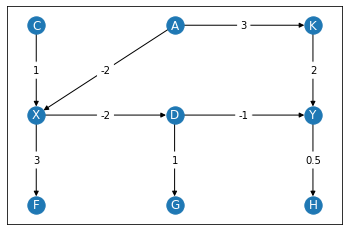

In [143]:
plot_example(G, G_positions)
plt.savefig('figs/original_G.png')

As we are in a linear causal setting, and the noise is gaussian, we know that rhw

We have the SCM structure implemented in the graph finally.

In [8]:
def who_depends_on_who(G, seed=1, n=500):
    parent_nodes = [node for node in G.nodes() if len(list(G.predecessors(node)))==0]
    random = np.random.RandomState(seed)
    nodes_total = {i:str(nx.get_node_attributes(G,'noise')[i])+'N' for i in G.nodes()}#random.normal(size=n)
    q = queue.SimpleQueue()
    for node in nx.topological_sort(G):
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            weight = G.get_edge_data(node,neighbor)['weight']
            nodes_total[neighbor] += ' + '+str(weight)+node+''#weight*nodes_total[node]
    return nodes_total

In [9]:
who_depends_on_who(G)

{'A': '0.8N',
 'C': '1N',
 'D': '0.5N + -2X',
 'F': '0.8N + 3X',
 'K': '0.1N + 3A',
 'G': '0.5N + 1D',
 'H': '0.1N + 0.5Y',
 'X': '0.2N + 1C + -2A',
 'Y': '0.2N + 2K + -1D'}

We just need to create data for this equations

In [10]:
def compute_causal_variables(G, seed=1, n=500):
    parent_nodes = [node for node in G.nodes() if len(list(G.predecessors(node)))==0]
    random = np.random.RandomState(seed)
    nodes_total = {i:nx.get_node_attributes(G,'noise')[i]*random.normal(size=n) for i in G.nodes()}
    q = queue.SimpleQueue()
    for node in nx.topological_sort(G):
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            weight = G.get_edge_data(node,neighbor)['weight']
            #print('{}->{}, w:{}'.format(node, neighbor, weight))
            nodes_total[neighbor] += weight*nodes_total[node]
    return nodes_total

In [11]:
causal_variables = compute_causal_variables(G)

Now we are interested in determining (from data) the effect that X has on Y. We have two paths that connect X to Y, X <- A -> K -> Y and X -> D -> Y. The first path is what we call a **backdoor path**, we have a common cause (A or K) between our two study variables: that's called a **confounder**. We need to take that into account: intuitively we'll condition the two variables to the common cause, so we can see the direct link. That's called **adjusting**<br>

A typical example of this is the kidney stones example, in which we are deciding if treatment A is better than B. At first we see that treatment B solves more

In [12]:
def coefficients_regression(X, y):
    if type(X)==list:
        X = np.array(X)
    if len(X.shape)==1:
        X = X.reshape(1, -1)    
    regr = linear_model.LinearRegression()
    regr.fit(X.T, y)
    return regr.coef_

In [13]:
def get_coeffs(causal_variables, labels_in, label_out):
    coeffs = coefficients_regression([causal_variables[label] for label in labels_in],causal_variables[label_out])
    return {x:coeffs[i] for i,x in enumerate(labels_in)}

If we compute the linear regression in variables that are already connected we can see how the weights are directly the regression coefficients:

In [14]:
get_coeffs(causal_variables,'C','X')

{'C': 0.9769386499648419}

In [15]:
get_coeffs(causal_variables,'X','F')

{'X': 2.9997477377077892}

The problem is when we try to find out (without knowing the graph), what's the influence of X -> Y. We know, because we created the graph that the $C_{X\rightarrow Y}=2$. But the regression coefficient is:

In [16]:
get_coeffs(causal_variables,'X','Y')

{'X': -0.14930154918400246}

What we do is instead of doing the curve-fitting directly from Y to X, we do multilinear regression with the nodes that block the backdoor. 

In [17]:
get_coeffs(causal_variables,['X','K'],'Y')

{'X': 1.9863259727652414, 'K': 1.9822732174800048}

In [18]:
get_coeffs(causal_variables,['X','A'],'Y')

{'X': 1.9802614561990557, 'A': 5.93555343398106}

And we could also do it for $C_{X->H}$, as Y is its only parent

In [19]:
get_coeffs(causal_variables,['X','A'],'H')

{'X': 0.9970147298479458, 'A': 2.9890201748263747}

This practical example shows the importance of causality, without knowing the graph we couldn't say anything on the impact that X has on Y. Even with the best machine learning models, we would fit the wrong system, if we are only taking into account these two variables. Causality gives us tools to operate with these causal graphs in order to understand the system.

The problem is that figuring our the DAG from a given dataset is NP-hard as there are exponentially differents DAGs for each number of nodes.

In [20]:
def plot_graph(G):
    if type(G)!=np.ndarray:
        numpy_array_G = nx.to_numpy_matrix(G)
    else: 
        numpy_array_G = G
    plt.matshow(numpy_array_G,cmap='viridis')
    plt.colorbar()

Here we plot the adjency matrix of G with the weights. This will be useful when creating a model of the graph, and comparing with the reality.

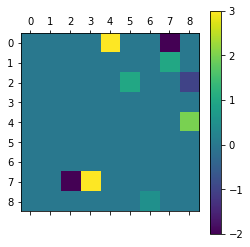

In [21]:
plot_graph(G)

# DAG-GNN

The goal of our article is to check which kind of graphs can be infered from data. For this we we'll use the paper *DAG-GNN: DAG Structure Learning with Graph Neural Networks (Yue Yu et Al, 2019)*.

For sake of simplicity we don't scale differently the noises on each random variable.

In [236]:
import train
import utils

In [237]:

importlib.reload(utils)
importlib.reload(train)

<module 'train' from 'C:\\Users\\berna\\datascience\\machine_learning\\article\\exploring-causality\\train.py'>

In [176]:
nx.to_numpy_matrix(G).shape

(9, 9)

- Changing noises: we will change the noises only here

In [199]:
noises_dict = {}
for noise in ['linear-gauss','linear-gumbel', 'linear-exp']:
    G_original, G_, acc, loss=train.create_model_and_train(graph_truth=nx.DiGraph(nx.to_numpy_matrix(G)),
                                                   data_sample_size=5000,
                                                   graph_sem_type=noise,
                                                   k_max_iter=5)
    new_value = acc
    new_value['loss']=loss
    new_value['G_']=nx.relabel.relabel_nodes(nx.DiGraph(np.around(G_,2)),{0:"A", 1:"C", 2:"D", 3:"F", 4:"K", 5:"G", 6:"H", 7:"X", 8:"Y"})
    noises_dict[noise]=new_value

Epoch: 0000 nll_train: 1.3368609057 kl_train: 0.5471532337 ELBO_loss: 1.8840141394 mse_train: 0.2970802013 time: 2.2746s
Epoch: 0001 nll_train: 0.0614927324 kl_train: 0.0860674811 ELBO_loss: 0.1475602135 mse_train: 0.0136650517 time: 2.2517s
Epoch: 0002 nll_train: 0.0428092325 kl_train: 0.0586552339 ELBO_loss: 0.1014644664 mse_train: 0.0095131628 time: 2.3920s
Epoch: 0003 nll_train: 0.0573643931 kl_train: 0.0527559871 ELBO_loss: 0.1101203802 mse_train: 0.0127476429 time: 2.8726s
Epoch: 0004 nll_train: 0.0611766445 kl_train: 0.0448164595 ELBO_loss: 0.1059931040 mse_train: 0.0135948099 time: 2.6975s
Epoch: 0005 nll_train: 0.0165417745 kl_train: 0.0363864133 ELBO_loss: 0.0529281878 mse_train: 0.0036759499 time: 2.4436s
Epoch: 0006 nll_train: 0.0325711637 kl_train: 0.0285154906 ELBO_loss: 0.0610866543 mse_train: 0.0072380364 time: 2.8330s
Epoch: 0007 nll_train: 0.0369942325 kl_train: 0.0273361628 ELBO_loss: 0.0643303953 mse_train: 0.0082209405 time: 2.5727s
Epoch: 0008 nll_train: 0.0158628

Epoch: 0005 nll_train: 0.0002570226 kl_train: 0.0021446968 ELBO_loss: 0.0024017194 mse_train: 0.0000571161 time: 2.2952s
Epoch: 0006 nll_train: 0.0011132817 kl_train: 0.0020990721 ELBO_loss: 0.0032123538 mse_train: 0.0002473959 time: 2.4240s
Epoch: 0007 nll_train: 0.0002811372 kl_train: 0.0020579415 ELBO_loss: 0.0023390787 mse_train: 0.0000624749 time: 2.5062s
Epoch: 0008 nll_train: 0.0004965299 kl_train: 0.0020138941 ELBO_loss: 0.0025104241 mse_train: 0.0001103400 time: 2.2726s
Epoch: 0009 nll_train: 0.0006685294 kl_train: 0.0019731673 ELBO_loss: 0.0026416967 mse_train: 0.0001485621 time: 2.5309s
Optimization Finished!
Best Epoch: 0007
Epoch: 0000 nll_train: 0.0000463992 kl_train: 0.0019852738 ELBO_loss: 0.0020316730 mse_train: 0.0000103109 time: 2.3812s
Epoch: 0001 nll_train: 0.0001223518 kl_train: 0.0019504380 ELBO_loss: 0.0020727898 mse_train: 0.0000271893 time: 2.9931s
Epoch: 0002 nll_train: 0.0001596783 kl_train: 0.0019109206 ELBO_loss: 0.0020705989 mse_train: 0.0000354841 time: 

Optimization Finished!
Best Epoch: 0008
Epoch: 0000 nll_train: 0.0013328013 kl_train: 0.0058785480 ELBO_loss: 0.0072113494 mse_train: 0.0002961781 time: 2.1797s
Epoch: 0001 nll_train: 0.0003645627 kl_train: 0.0056801421 ELBO_loss: 0.0060447048 mse_train: 0.0000810139 time: 2.1934s
Epoch: 0002 nll_train: 0.0013577676 kl_train: 0.0054711765 ELBO_loss: 0.0068289441 mse_train: 0.0003017261 time: 2.1774s
Epoch: 0003 nll_train: 0.0424826358 kl_train: 0.0053437700 ELBO_loss: 0.0478264057 mse_train: 0.0094405857 time: 2.1578s
Epoch: 0004 nll_train: 0.0002639192 kl_train: 0.0055020466 ELBO_loss: 0.0057659658 mse_train: 0.0000586487 time: 2.1653s
Epoch: 0005 nll_train: 0.0001178825 kl_train: 0.0053671160 ELBO_loss: 0.0054849986 mse_train: 0.0000261961 time: 2.1636s
Epoch: 0006 nll_train: 0.0001849094 kl_train: 0.0052194029 ELBO_loss: 0.0054043123 mse_train: 0.0000410910 time: 2.1871s
Epoch: 0007 nll_train: 0.0016348719 kl_train: 0.0050534283 ELBO_loss: 0.0066883003 mse_train: 0.0003633049 time: 

Epoch: 0004 nll_train: 0.0001290499 kl_train: 0.0056958507 ELBO_loss: 0.0058249005 mse_train: 0.0000286777 time: 2.5557s
Epoch: 0005 nll_train: 0.0001073795 kl_train: 0.0054950189 ELBO_loss: 0.0056023984 mse_train: 0.0000238621 time: 2.2564s
Epoch: 0006 nll_train: 0.0087554881 kl_train: 0.0053268758 ELBO_loss: 0.0140823639 mse_train: 0.0019456640 time: 2.3247s
Epoch: 0007 nll_train: 0.0014568259 kl_train: 0.0052628344 ELBO_loss: 0.0067196602 mse_train: 0.0003237391 time: 2.4336s
Epoch: 0008 nll_train: 0.0032739528 kl_train: 0.0051060464 ELBO_loss: 0.0083799992 mse_train: 0.0007275451 time: 2.3808s
Epoch: 0009 nll_train: 0.0387802516 kl_train: 0.0050975864 ELBO_loss: 0.0438778380 mse_train: 0.0086178337 time: 2.2684s
Optimization Finished!
Best Epoch: 0005
Epoch: 0000 nll_train: 0.0001800861 kl_train: 0.0052523954 ELBO_loss: 0.0054324815 mse_train: 0.0000400191 time: 2.3253s
Epoch: 0001 nll_train: 0.0000427159 kl_train: 0.0051045375 ELBO_loss: 0.0051472534 mse_train: 0.0000094924 time: 

- Changing sample sizes: we will change the amount of data in all the variables

In [200]:
sample_size_dict = {}
for size in [1000,5000,10000,20000]:
    G_original, G_, acc, loss=train.create_model_and_train(graph_truth=nx.DiGraph(nx.to_numpy_matrix(G)),
                                                   data_sample_size=size,
                                                   graph_sem_type='linear-gauss',
                                                   k_max_iter=5)
    new_value = acc
    new_value['loss']=loss
    new_value['G_']=nx.relabel.relabel_nodes(nx.DiGraph(np.around(G_,2)),{0:"A", 1:"C", 2:"D", 3:"F", 4:"K", 5:"G", 6:"H", 7:"X", 8:"Y"})
    sample_size_dict[size]=new_value

Epoch: 0000 nll_train: 7.0142636785 kl_train: 2.0480188796 ELBO_loss: 9.0622825581 mse_train: 1.5587252619 time: 0.6042s
Epoch: 0001 nll_train: 0.0253253843 kl_train: 0.4490540749 ELBO_loss: 0.4743794592 mse_train: 0.0056278632 time: 0.6214s
Epoch: 0002 nll_train: 0.0445057996 kl_train: 0.2073526328 ELBO_loss: 0.2518584324 mse_train: 0.0098901777 time: 0.4756s
Epoch: 0003 nll_train: 0.0896514582 kl_train: 0.1576845668 ELBO_loss: 0.2473360250 mse_train: 0.0199225463 time: 0.5730s
Epoch: 0004 nll_train: 0.0208435847 kl_train: 0.1161205512 ELBO_loss: 0.1369641359 mse_train: 0.0046319077 time: 0.5027s
Epoch: 0005 nll_train: 0.0876706676 kl_train: 0.1006871989 ELBO_loss: 0.1883578665 mse_train: 0.0194823706 time: 0.5176s
Epoch: 0006 nll_train: 0.0315803885 kl_train: 0.0863218222 ELBO_loss: 0.1179022107 mse_train: 0.0070178641 time: 0.4934s
Epoch: 0007 nll_train: 0.1408631330 kl_train: 0.0912816105 ELBO_loss: 0.2321447434 mse_train: 0.0313029184 time: 0.5488s
Epoch: 0008 nll_train: 0.0715606

Epoch: 0005 nll_train: 0.0002244995 kl_train: 0.0149384634 ELBO_loss: 0.0151629629 mse_train: 0.0000498888 time: 0.4515s
Epoch: 0006 nll_train: 0.0002434999 kl_train: 0.0146521655 ELBO_loss: 0.0148956654 mse_train: 0.0000541111 time: 0.4714s
Epoch: 0007 nll_train: 0.0002640079 kl_train: 0.0143670995 ELBO_loss: 0.0146311074 mse_train: 0.0000586684 time: 0.4480s
Epoch: 0008 nll_train: 0.0002720419 kl_train: 0.0140854118 ELBO_loss: 0.0143574536 mse_train: 0.0000604538 time: 0.4586s
Epoch: 0009 nll_train: 0.0002598400 kl_train: 0.0137992785 ELBO_loss: 0.0140591185 mse_train: 0.0000577422 time: 0.4463s
Optimization Finished!
Best Epoch: 0009
Epoch: 0000 nll_train: 1.4832864014 kl_train: 0.5663454613 ELBO_loss: 2.0496318627 mse_train: 0.3296192003 time: 2.3418s
Epoch: 0001 nll_train: 0.0615031494 kl_train: 0.0846591395 ELBO_loss: 0.1461622890 mse_train: 0.0136673665 time: 2.2001s
Epoch: 0002 nll_train: 0.0594467543 kl_train: 0.0611710640 ELBO_loss: 0.1206178184 mse_train: 0.0132103899 time: 

Optimization Finished!
Best Epoch: 0008
Epoch: 0000 nll_train: 0.0002376543 kl_train: 0.0020449361 ELBO_loss: 0.0022825903 mse_train: 0.0000528121 time: 2.8244s
Epoch: 0001 nll_train: 0.0019710424 kl_train: 0.0020091078 ELBO_loss: 0.0039801503 mse_train: 0.0004380094 time: 2.4285s
Epoch: 0002 nll_train: 0.0001901857 kl_train: 0.0019763243 ELBO_loss: 0.0021665100 mse_train: 0.0000422635 time: 2.6696s
Epoch: 0003 nll_train: 0.0010153889 kl_train: 0.0019383141 ELBO_loss: 0.0029537030 mse_train: 0.0002256420 time: 2.2980s
Epoch: 0004 nll_train: 0.0003475098 kl_train: 0.0019024233 ELBO_loss: 0.0022499331 mse_train: 0.0000772244 time: 2.6701s
Epoch: 0005 nll_train: 0.0007360124 kl_train: 0.0018656877 ELBO_loss: 0.0026017001 mse_train: 0.0001635583 time: 2.2864s
Epoch: 0006 nll_train: 0.0013866344 kl_train: 0.0018342953 ELBO_loss: 0.0032209297 mse_train: 0.0003081410 time: 2.5381s
Epoch: 0007 nll_train: 0.0001321767 kl_train: 0.0018048059 ELBO_loss: 0.0019369825 mse_train: 0.0000293726 time: 

Epoch: 0004 nll_train: 0.0020493825 kl_train: 0.0022357945 ELBO_loss: 0.0042851770 mse_train: 0.0004554183 time: 4.7125s
Epoch: 0005 nll_train: 0.0017148812 kl_train: 0.0021489015 ELBO_loss: 0.0038637828 mse_train: 0.0003810847 time: 4.2965s
Epoch: 0006 nll_train: 0.0022810763 kl_train: 0.0020922181 ELBO_loss: 0.0043732944 mse_train: 0.0005069058 time: 4.2640s
Epoch: 0007 nll_train: 0.0015574041 kl_train: 0.0020271723 ELBO_loss: 0.0035845764 mse_train: 0.0003460898 time: 4.2655s
Epoch: 0008 nll_train: 0.0014693950 kl_train: 0.0019627235 ELBO_loss: 0.0034321185 mse_train: 0.0003265322 time: 4.2515s
Epoch: 0009 nll_train: 0.0037295220 kl_train: 0.0019261493 ELBO_loss: 0.0056556714 mse_train: 0.0008287827 time: 4.2521s
Optimization Finished!
Best Epoch: 0003
Epoch: 0000 nll_train: 0.0014841033 kl_train: 0.0019049727 ELBO_loss: 0.0033890760 mse_train: 0.0003298007 time: 4.2459s
Epoch: 0001 nll_train: 0.0046626987 kl_train: 0.0018804928 ELBO_loss: 0.0065431916 mse_train: 0.0010361553 time: 

Epoch: 0009 nll_train: 0.0019507203 kl_train: 0.0018427180 ELBO_loss: 0.0037934382 mse_train: 0.0004334934 time: 8.9049s
Optimization Finished!
Best Epoch: 0003
Epoch: 0000 nll_train: 0.0017355320 kl_train: 0.0017777541 ELBO_loss: 0.0035132861 mse_train: 0.0003856738 time: 8.6565s
Epoch: 0001 nll_train: 0.0020601420 kl_train: 0.0017138340 ELBO_loss: 0.0037739760 mse_train: 0.0004578093 time: 8.4544s
Epoch: 0002 nll_train: 0.0020032030 kl_train: 0.0016692947 ELBO_loss: 0.0036724977 mse_train: 0.0004451562 time: 8.4687s
Epoch: 0003 nll_train: 0.0023866823 kl_train: 0.0016179306 ELBO_loss: 0.0040046129 mse_train: 0.0005303738 time: 8.8037s
Epoch: 0004 nll_train: 0.0015157456 kl_train: 0.0015773154 ELBO_loss: 0.0030930610 mse_train: 0.0003368323 time: 8.5679s
Epoch: 0005 nll_train: 0.0019651236 kl_train: 0.0015346665 ELBO_loss: 0.0034997902 mse_train: 0.0004366941 time: 8.6135s
Epoch: 0006 nll_train: 0.0025965777 kl_train: 0.0015100867 ELBO_loss: 0.0041066644 mse_train: 0.0005770173 time: 

- Changing linear equations: the paper DAG-GNN is based on neural networks. The complex mathematical behaviour of the networks allows us to test not only linear transformations, but also non linear ones. This means that the laws behind a causal connection are not $X=wY+N$ but $X=wh(Y)+N$ where $h$ is nonlinear. The difference between `nonlinear_1` and `nonlinear_2` is in applying a the linear transformation before or after the non linear function.

In [201]:
linear_type_dict = {}
for linear_type in ['linear','nonlinear_1','nonlinear_2']:
    G_original, G_, acc, loss =train.create_model_and_train(graph_truth=nx.DiGraph(nx.to_numpy_matrix(G)),
                                                   data_sample_size=5000,
                                                   graph_sem_type='linear-gauss',
                                                   k_max_iter=5)
    new_value = acc
    new_value['loss']=loss
    new_value['G_']=nx.relabel.relabel_nodes(nx.DiGraph(np.around(G_,2)),{0:"A", 1:"C", 2:"D", 3:"F", 4:"K", 5:"G", 6:"H", 7:"X", 8:"Y"})
    linear_type_dict[linear_type]=new_value

Epoch: 0000 nll_train: 1.3567218394 kl_train: 0.5751214902 ELBO_loss: 1.9318433296 mse_train: 0.3014937421 time: 2.2567s
Epoch: 0001 nll_train: 0.0862837808 kl_train: 0.0881041831 ELBO_loss: 0.1743879639 mse_train: 0.0191741735 time: 2.2092s
Epoch: 0002 nll_train: 0.0091761757 kl_train: 0.0693785497 ELBO_loss: 0.0785547255 mse_train: 0.0020391502 time: 2.1547s
Epoch: 0003 nll_train: 0.0572720380 kl_train: 0.0487406891 ELBO_loss: 0.1060127270 mse_train: 0.0127271195 time: 2.1924s
Epoch: 0004 nll_train: 0.0231983389 kl_train: 0.0377350938 ELBO_loss: 0.0609334327 mse_train: 0.0051551864 time: 2.1188s
Epoch: 0005 nll_train: 0.0674723718 kl_train: 0.0447036708 ELBO_loss: 0.1121760426 mse_train: 0.0149938604 time: 2.1400s
Epoch: 0006 nll_train: 0.0493854343 kl_train: 0.0289233643 ELBO_loss: 0.0783087986 mse_train: 0.0109745410 time: 2.3477s
Epoch: 0007 nll_train: 0.0026342192 kl_train: 0.0293650485 ELBO_loss: 0.0319992677 mse_train: 0.0005853820 time: 2.1359s
Epoch: 0008 nll_train: 0.0464018

Epoch: 0005 nll_train: 0.0007248940 kl_train: 0.0023545267 ELBO_loss: 0.0030794207 mse_train: 0.0001610876 time: 2.0715s
Epoch: 0006 nll_train: 0.0006253323 kl_train: 0.0023034763 ELBO_loss: 0.0029288086 mse_train: 0.0001389627 time: 2.1190s
Epoch: 0007 nll_train: 0.0004826313 kl_train: 0.0022558160 ELBO_loss: 0.0027384473 mse_train: 0.0001072514 time: 2.0933s
Epoch: 0008 nll_train: 0.0001131880 kl_train: 0.0022029185 ELBO_loss: 0.0023161065 mse_train: 0.0000251529 time: 2.0891s
Epoch: 0009 nll_train: 0.0015700596 kl_train: 0.0021662477 ELBO_loss: 0.0037363074 mse_train: 0.0003489021 time: 2.3584s
Optimization Finished!
Best Epoch: 0008
Epoch: 0000 nll_train: 0.0000152190 kl_train: 0.0022087245 ELBO_loss: 0.0022239436 mse_train: 0.0000033820 time: 2.0767s
Epoch: 0001 nll_train: 0.0000218321 kl_train: 0.0021685934 ELBO_loss: 0.0021904256 mse_train: 0.0000048516 time: 2.0654s
Epoch: 0002 nll_train: 0.0004343642 kl_train: 0.0021268800 ELBO_loss: 0.0025612442 mse_train: 0.0000965254 time: 

Optimization Finished!
Best Epoch: 0006
Epoch: 0000 nll_train: 0.0004293207 kl_train: 0.0024454277 ELBO_loss: 0.0028747484 mse_train: 0.0000954046 time: 2.0957s
Epoch: 0001 nll_train: 0.0004480690 kl_train: 0.0023872329 ELBO_loss: 0.0028353019 mse_train: 0.0000995709 time: 2.0967s
Epoch: 0002 nll_train: 0.0005181017 kl_train: 0.0023255192 ELBO_loss: 0.0028436210 mse_train: 0.0001151337 time: 2.3243s
Epoch: 0003 nll_train: 0.0018204957 kl_train: 0.0022728824 ELBO_loss: 0.0040933781 mse_train: 0.0004045546 time: 2.0844s
Epoch: 0004 nll_train: 0.0001799240 kl_train: 0.0022323237 ELBO_loss: 0.0024122477 mse_train: 0.0000399831 time: 2.1215s
Epoch: 0005 nll_train: 0.0011188476 kl_train: 0.0021822190 ELBO_loss: 0.0033010666 mse_train: 0.0002486328 time: 2.0949s
Epoch: 0006 nll_train: 0.0025696236 kl_train: 0.0021695765 ELBO_loss: 0.0047392001 mse_train: 0.0005710275 time: 2.1313s
Epoch: 0007 nll_train: 0.0001132366 kl_train: 0.0021258891 ELBO_loss: 0.0022391257 mse_train: 0.0000251637 time: 

Epoch: 0004 nll_train: 0.0162696741 kl_train: 0.0154464836 ELBO_loss: 0.0317161577 mse_train: 0.0036154831 time: 2.0961s
Epoch: 0005 nll_train: 0.0285215779 kl_train: 0.0154947475 ELBO_loss: 0.0440163254 mse_train: 0.0063381284 time: 2.1171s
Epoch: 0006 nll_train: 0.0306385423 kl_train: 0.0142238733 ELBO_loss: 0.0448624155 mse_train: 0.0068085649 time: 2.0992s
Epoch: 0007 nll_train: 0.0077138523 kl_train: 0.0127433625 ELBO_loss: 0.0204572148 mse_train: 0.0017141894 time: 2.0922s
Epoch: 0008 nll_train: 0.0248597174 kl_train: 0.0129842613 ELBO_loss: 0.0378439787 mse_train: 0.0055243816 time: 2.0932s
Epoch: 0009 nll_train: 0.0173304702 kl_train: 0.0110655063 ELBO_loss: 0.0283959765 mse_train: 0.0038512156 time: 2.1000s
Optimization Finished!
Best Epoch: 0007
Epoch: 0000 nll_train: 0.0316539122 kl_train: 0.0121235683 ELBO_loss: 0.0437774804 mse_train: 0.0070342027 time: 2.1103s
Epoch: 0001 nll_train: 0.0045827403 kl_train: 0.0102972512 ELBO_loss: 0.0148799916 mse_train: 0.0010183867 time: 

Epoch: 0009 nll_train: 0.0006036829 kl_train: 0.0016333147 ELBO_loss: 0.0022369976 mse_train: 0.0001341518 time: 2.1828s
Optimization Finished!
Best Epoch: 0008
Epoch: 0000 nll_train: 0.0001009698 kl_train: 0.0016083644 ELBO_loss: 0.0017093342 mse_train: 0.0000224377 time: 2.2335s
Epoch: 0001 nll_train: 0.0000938545 kl_train: 0.0015869219 ELBO_loss: 0.0016807764 mse_train: 0.0000208566 time: 2.1089s
Epoch: 0002 nll_train: 0.0002384964 kl_train: 0.0015657841 ELBO_loss: 0.0018042804 mse_train: 0.0000529992 time: 2.3724s
Epoch: 0003 nll_train: 0.0002057746 kl_train: 0.0015450100 ELBO_loss: 0.0017507847 mse_train: 0.0000457277 time: 2.1901s
Epoch: 0004 nll_train: 0.0002755999 kl_train: 0.0015254343 ELBO_loss: 0.0018010342 mse_train: 0.0000612444 time: 2.1702s
Epoch: 0005 nll_train: 0.0002304146 kl_train: 0.0015059841 ELBO_loss: 0.0017363988 mse_train: 0.0000512033 time: 2.1836s
Epoch: 0006 nll_train: 0.0002311395 kl_train: 0.0014874570 ELBO_loss: 0.0017185965 mse_train: 0.0000513643 time: 

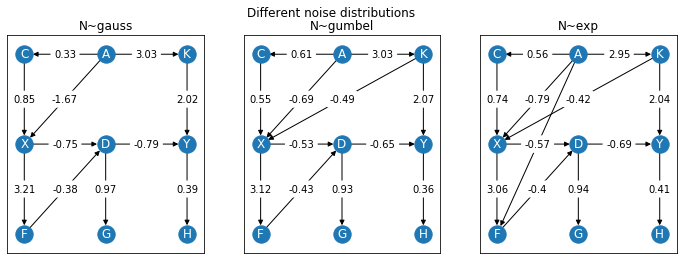

In [205]:
utils.compare_multiple_Gs(list(map(lambda x:x['G_'],noises_dict.values())), G_positions, label='Different noise distributions', labels_Gs=['N~gauss','N~gumbel', 'N~exp'])

In [244]:
noises_dict

{'linear-gauss': {'fdr': 0.18181818181818182,
  'tpr': 1.0,
  'fpr': 0.07407407407407407,
  'shd': 2,
  'pred_size': 11,
  'loss': 0.0015588971823496587,
  'G_': <networkx.classes.digraph.DiGraph at 0x1e61a86dbe0>},
 'linear-gumbel': {'fdr': 0.25,
  'tpr': 1.0,
  'fpr': 0.1111111111111111,
  'shd': 3,
  'pred_size': 12,
  'loss': 0.0044983822059254,
  'G_': <networkx.classes.digraph.DiGraph at 0x1e618608e80>},
 'linear-exp': {'fdr': 0.3076923076923077,
  'tpr': 1.0,
  'fpr': 0.14814814814814814,
  'shd': 4,
  'pred_size': 13,
  'loss': 0.0034648962831692683,
  'G_': <networkx.classes.digraph.DiGraph at 0x1e61a86def0>}}

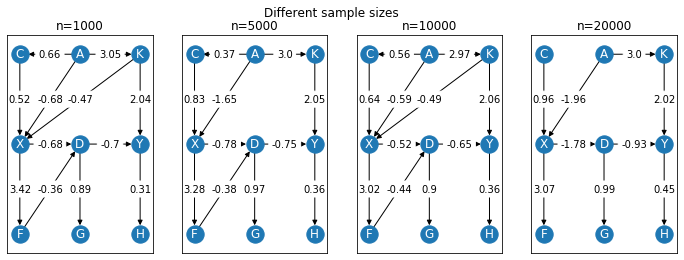

In [206]:
utils.compare_multiple_Gs(list(map(lambda x:x['G_'],sample_size_dict.values())), G_positions, label='Different sample sizes', labels_Gs=['n=1000','n=5000','n=10000','n=20000'])

In [242]:
sample_size_dict

{1000: {'fdr': 0.25,
  'tpr': 1.0,
  'fpr': 0.1111111111111111,
  'shd': 3,
  'pred_size': 12,
  'loss': 0.014059118511179849,
  'G_': <networkx.classes.digraph.DiGraph at 0x1e619013470>},
 5000: {'fdr': 0.18181818181818182,
  'tpr': 1.0,
  'fpr': 0.07407407407407407,
  'shd': 2,
  'pred_size': 11,
  'loss': 0.0014270285823898,
  'G_': <networkx.classes.digraph.DiGraph at 0x1e618964c88>},
 10000: {'fdr': 0.25,
  'tpr': 1.0,
  'fpr': 0.1111111111111111,
  'shd': 3,
  'pred_size': 12,
  'loss': 0.0016379203568572603,
  'G_': <networkx.classes.digraph.DiGraph at 0x1e61913fb00>},
 20000: {'fdr': 0.0,
  'tpr': 1.0,
  'fpr': 0.0,
  'shd': 0,
  'pred_size': 9,
  'loss': 0.0007608803182518497,
  'G_': <networkx.classes.digraph.DiGraph at 0x1e618772f98>}}

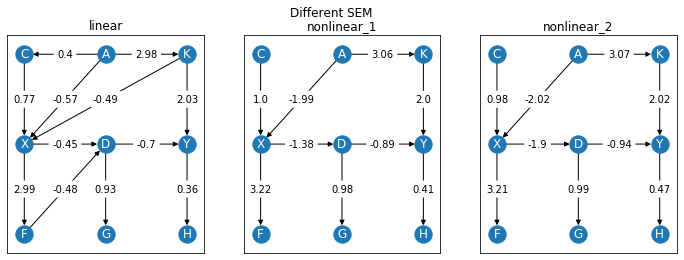

In [207]:
utils.compare_multiple_Gs(list(map(lambda x:x['G_'],linear_type_dict.values())), G_positions, label='Different SEM', labels_Gs=['linear','nonlinear_1','nonlinear_2'])

In [243]:
linear_type_dict

{'linear': {'fdr': 0.25,
  'tpr': 1.0,
  'fpr': 0.1111111111111111,
  'shd': 3,
  'pred_size': 12,
  'loss': 0.0018950845992493101,
  'G_': <networkx.classes.digraph.DiGraph at 0x1e619156e48>},
 'nonlinear_1': {'fdr': 0.0,
  'tpr': 1.0,
  'fpr': 0.0,
  'shd': 0,
  'pred_size': 9,
  'loss': 0.001470489647045204,
  'G_': <networkx.classes.digraph.DiGraph at 0x1e619013c88>},
 'nonlinear_2': {'fdr': 0.0,
  'tpr': 1.0,
  'fpr': 0.0,
  'shd': 0,
  'pred_size': 9,
  'loss': 0.0014237644381486813,
  'G_': <networkx.classes.digraph.DiGraph at 0x1e61896bf60>}}

In [239]:
linear_model = linear_type_dict['linear']['G_']

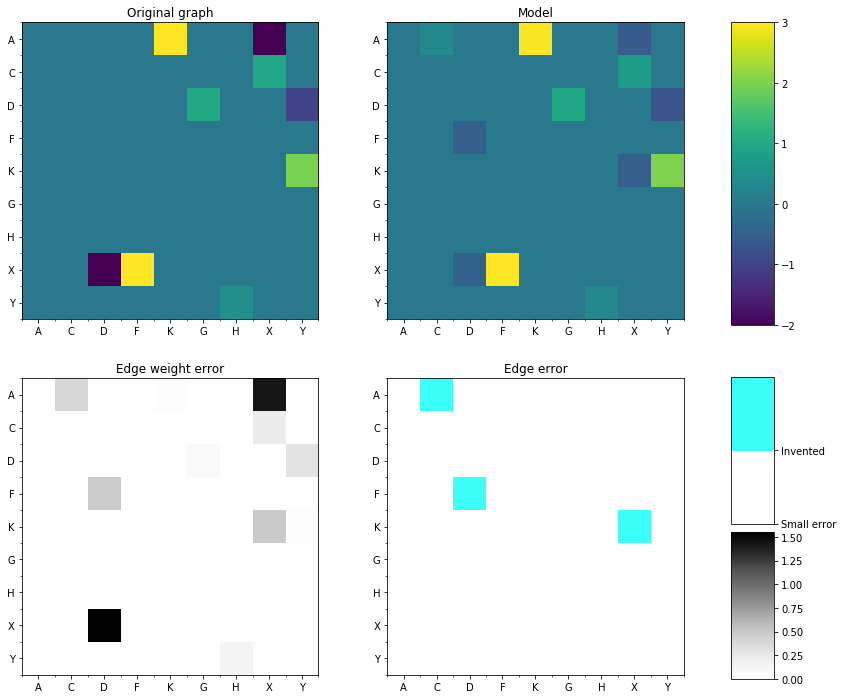

In [241]:
utils.plot_graphs(G, linear_model, ticks_labels=["A","C","D","F","K","G","H","X","Y"])

# Finding general patterns

Here we create more general studies with some seeds and changing nodes & graph degree

In [256]:
seed_dict = {}
for s in [41,42,43]:
    nodes_dict_s = {}
    for n in [10, 30, 50, 75]:
        G_original, G_, acc, loss =train.create_model_and_train(seed=s,
                                                       data_sample_size=5000,
                                                       data_variable_size=n, 
                                                       graph_degree=3,
                                                       graph_sem_type='linear-gauss',
                                                       k_max_iter=3)
        new_value = acc
        new_value['loss']=loss
        new_value['G_']=nx.DiGraph(np.around(G_,2))
        new_value['G']=G_original
        nodes_dict_s[n]=new_value
    seed_dict[s]=nodes_dict_s

Epoch: 0000 nll_train: 0.4475077429 kl_train: 0.2562658340 ELBO_loss: 0.7037735769 mse_train: 0.0895015486 time: 5.1779s
Epoch: 0001 nll_train: 0.0256466556 kl_train: 0.0447227807 ELBO_loss: 0.0703694363 mse_train: 0.0051293311 time: 5.5152s
Epoch: 0002 nll_train: 0.0309703969 kl_train: 0.0321433906 ELBO_loss: 0.0631137875 mse_train: 0.0061940794 time: 6.8820s
Epoch: 0003 nll_train: 0.0423796268 kl_train: 0.0302253631 ELBO_loss: 0.0726049900 mse_train: 0.0084759254 time: 6.8597s
Epoch: 0004 nll_train: 0.0334023336 kl_train: 0.0306341244 ELBO_loss: 0.0640364580 mse_train: 0.0066804667 time: 6.6190s
Epoch: 0005 nll_train: 0.0220222996 kl_train: 0.0215174729 ELBO_loss: 0.0435397725 mse_train: 0.0044044599 time: 5.5453s
Epoch: 0006 nll_train: 0.0235083208 kl_train: 0.0209080076 ELBO_loss: 0.0444163284 mse_train: 0.0047016642 time: 5.8456s
Epoch: 0007 nll_train: 0.0293385296 kl_train: 0.0208067459 ELBO_loss: 0.0501452754 mse_train: 0.0058677059 time: 4.6172s
Epoch: 0008 nll_train: 0.0276792

Epoch: 0004 nll_train: 0.0366178036 kl_train: 0.0408144052 ELBO_loss: 0.0774322089 mse_train: 0.0024411869 time: 8.7555s
Epoch: 0005 nll_train: 0.0924894767 kl_train: 0.0439934586 ELBO_loss: 0.1364829353 mse_train: 0.0061659651 time: 7.0768s
Epoch: 0006 nll_train: 0.0341683989 kl_train: 0.0381696695 ELBO_loss: 0.0723380684 mse_train: 0.0022778933 time: 7.2539s
Epoch: 0007 nll_train: 0.0531189574 kl_train: 0.0376981175 ELBO_loss: 0.0908170749 mse_train: 0.0035412638 time: 7.7490s
Epoch: 0008 nll_train: 0.0424620559 kl_train: 0.0332121775 ELBO_loss: 0.0756742335 mse_train: 0.0028308037 time: 8.8373s
Epoch: 0009 nll_train: 0.0342820541 kl_train: 0.0298352356 ELBO_loss: 0.0641172897 mse_train: 0.0022854703 time: 8.3943s
Optimization Finished!
Best Epoch: 0009
Epoch: 0000 nll_train: 0.0010217867 kl_train: 0.0246342606 ELBO_loss: 0.0256560474 mse_train: 0.0000681191 time: 7.8243s
Epoch: 0001 nll_train: 0.0004821248 kl_train: 0.0220512890 ELBO_loss: 0.0225334138 mse_train: 0.0000321417 time: 

Epoch: 0008 nll_train: 0.0104113340 kl_train: 0.0199092952 ELBO_loss: 0.0303206292 mse_train: 0.0004164534 time: 9.9441s
Epoch: 0009 nll_train: 0.0097710219 kl_train: 0.0188494610 ELBO_loss: 0.0286204829 mse_train: 0.0003908409 time: 9.1961s
Optimization Finished!
Best Epoch: 0009
Epoch: 0000 nll_train: 0.0122111776 kl_train: 0.0181373004 ELBO_loss: 0.0303484780 mse_train: 0.0004884471 time: 9.3607s
Epoch: 0001 nll_train: 0.0146681695 kl_train: 0.0173449160 ELBO_loss: 0.0320130855 mse_train: 0.0005867268 time: 8.7982s
Epoch: 0002 nll_train: 0.0081188089 kl_train: 0.0166955079 ELBO_loss: 0.0248143168 mse_train: 0.0003247524 time: 9.0224s
Epoch: 0003 nll_train: 0.0125652024 kl_train: 0.0160454842 ELBO_loss: 0.0286106866 mse_train: 0.0005026081 time: 10.6819s
Epoch: 0004 nll_train: 0.0118016349 kl_train: 0.0154505378 ELBO_loss: 0.0272521727 mse_train: 0.0004720654 time: 9.2400s
Epoch: 0005 nll_train: 0.0117072078 kl_train: 0.0149639690 ELBO_loss: 0.0266711768 mse_train: 0.0004682883 time:

Epoch: 0001 nll_train: 0.0763417130 kl_train: 0.1182470765 ELBO_loss: 0.1945887895 mse_train: 0.0152683426 time: 5.9685s
Epoch: 0002 nll_train: 0.0959494191 kl_train: 0.0832248091 ELBO_loss: 0.1791742282 mse_train: 0.0191898838 time: 5.3874s
Epoch: 0003 nll_train: 0.0318364121 kl_train: 0.0617635015 ELBO_loss: 0.0935999136 mse_train: 0.0063672824 time: 5.1971s
Epoch: 0004 nll_train: 0.0560504767 kl_train: 0.0515800834 ELBO_loss: 0.1076305601 mse_train: 0.0112100953 time: 5.0037s
Epoch: 0005 nll_train: 0.2010232336 kl_train: 0.0414953979 ELBO_loss: 0.2425186315 mse_train: 0.0402046467 time: 5.0085s
Epoch: 0006 nll_train: 0.0113385996 kl_train: 0.0583279741 ELBO_loss: 0.0696665737 mse_train: 0.0022677199 time: 5.7361s
Epoch: 0007 nll_train: 0.0024137809 kl_train: 0.0368645676 ELBO_loss: 0.0392783485 mse_train: 0.0004827562 time: 5.3072s
Epoch: 0008 nll_train: 0.1580567829 kl_train: 0.0296243600 ELBO_loss: 0.1876811429 mse_train: 0.0316113566 time: 5.5807s
Epoch: 0009 nll_train: 0.0040492

Epoch: 0006 nll_train: 0.0031010681 kl_train: 0.0111038995 ELBO_loss: 0.0142049675 mse_train: 0.0002067379 time: 8.3682s
Epoch: 0007 nll_train: 0.0053257411 kl_train: 0.0107090097 ELBO_loss: 0.0160347508 mse_train: 0.0003550494 time: 7.9030s
Epoch: 0008 nll_train: 0.0189486912 kl_train: 0.0105262786 ELBO_loss: 0.0294749698 mse_train: 0.0012632461 time: 7.2558s
Epoch: 0009 nll_train: 0.0001869010 kl_train: 0.0102545955 ELBO_loss: 0.0104414966 mse_train: 0.0000124601 time: 6.8891s
Optimization Finished!
Best Epoch: 0009
Epoch: 0000 nll_train: 0.0001735637 kl_train: 0.0095313741 ELBO_loss: 0.0097049378 mse_train: 0.0000115709 time: 7.0446s
Epoch: 0001 nll_train: 0.0000366584 kl_train: 0.0092962699 ELBO_loss: 0.0093329283 mse_train: 0.0000024439 time: 7.7355s
Epoch: 0002 nll_train: 0.0004320478 kl_train: 0.0090225629 ELBO_loss: 0.0094546107 mse_train: 0.0000288032 time: 7.7554s
Epoch: 0003 nll_train: 0.0034150730 kl_train: 0.0087773885 ELBO_loss: 0.0121924615 mse_train: 0.0002276715 time: 

Epoch: 0000 nll_train: 14.3029584112 kl_train: 5.4469821556 ELBO_loss: 19.7499405668 mse_train: 0.3814122243 time: 12.0013s
Epoch: 0001 nll_train: 0.2309796909 kl_train: 0.4396017575 ELBO_loss: 0.6705814484 mse_train: 0.0061594584 time: 12.3568s
Epoch: 0002 nll_train: 0.2169710913 kl_train: 0.3304506357 ELBO_loss: 0.5474217270 mse_train: 0.0057858958 time: 12.8507s
Epoch: 0003 nll_train: 0.1852592067 kl_train: 0.2521822201 ELBO_loss: 0.4374414267 mse_train: 0.0049402455 time: 12.9347s
Epoch: 0004 nll_train: 0.1814499133 kl_train: 0.2085600667 ELBO_loss: 0.3900099799 mse_train: 0.0048386644 time: 13.1362s
Epoch: 0005 nll_train: 0.2293712895 kl_train: 0.1877624731 ELBO_loss: 0.4171337625 mse_train: 0.0061165677 time: 12.5958s
Epoch: 0006 nll_train: 0.1576439349 kl_train: 0.1714435165 ELBO_loss: 0.3290874515 mse_train: 0.0042038383 time: 12.1181s
Epoch: 0007 nll_train: 0.1490766924 kl_train: 0.1580369966 ELBO_loss: 0.3071136889 mse_train: 0.0039753785 time: 12.2896s
Epoch: 0008 nll_train:

Epoch: 0003 nll_train: 0.0534115966 kl_train: 0.0306387496 ELBO_loss: 0.0840503461 mse_train: 0.0106823193 time: 6.0650s
Epoch: 0004 nll_train: 0.0248005487 kl_train: 0.0284645890 ELBO_loss: 0.0532651377 mse_train: 0.0049601097 time: 5.5595s
Epoch: 0005 nll_train: 0.0405126226 kl_train: 0.0249991706 ELBO_loss: 0.0655117932 mse_train: 0.0081025245 time: 5.9097s
Epoch: 0006 nll_train: 0.0947692283 kl_train: 0.0250039388 ELBO_loss: 0.1197731671 mse_train: 0.0189538457 time: 5.8124s
Epoch: 0007 nll_train: 0.0058007245 kl_train: 0.0264486516 ELBO_loss: 0.0322493762 mse_train: 0.0011601449 time: 6.0088s
Epoch: 0008 nll_train: 0.0481736197 kl_train: 0.0221378721 ELBO_loss: 0.0703114919 mse_train: 0.0096347239 time: 6.0199s
Epoch: 0009 nll_train: 0.0234691569 kl_train: 0.0221319564 ELBO_loss: 0.0456011133 mse_train: 0.0046938314 time: 6.9070s
Optimization Finished!
Best Epoch: 0007
Epoch: 0000 nll_train: 0.0005655551 kl_train: 0.0204437241 ELBO_loss: 0.0210092792 mse_train: 0.0001131110 time: 

Epoch: 0007 nll_train: 0.0068802859 kl_train: 0.0103675277 ELBO_loss: 0.0172478136 mse_train: 0.0004586857 time: 8.1446s
Epoch: 0008 nll_train: 0.0108431217 kl_train: 0.0100610250 ELBO_loss: 0.0209041467 mse_train: 0.0007228748 time: 8.3828s
Epoch: 0009 nll_train: 0.0097501842 kl_train: 0.0098758739 ELBO_loss: 0.0196260581 mse_train: 0.0006500123 time: 8.2008s
Optimization Finished!
Best Epoch: 0007
Epoch: 0000 nll_train: 0.0007419018 kl_train: 0.0094785768 ELBO_loss: 0.0102204786 mse_train: 0.0000494601 time: 8.0647s
Epoch: 0001 nll_train: 0.0006812678 kl_train: 0.0091320495 ELBO_loss: 0.0098133173 mse_train: 0.0000454179 time: 8.3000s
Epoch: 0002 nll_train: 0.0010050835 kl_train: 0.0087723860 ELBO_loss: 0.0097774695 mse_train: 0.0000670056 time: 7.9374s
Epoch: 0003 nll_train: 0.0024392174 kl_train: 0.0084302809 ELBO_loss: 0.0108694984 mse_train: 0.0001626145 time: 7.4581s
Epoch: 0004 nll_train: 0.0025367105 kl_train: 0.0081266333 ELBO_loss: 0.0106633437 mse_train: 0.0001691140 time: 

Epoch: 0000 nll_train: 41.0115835706 kl_train: 18.0404959031 ELBO_loss: 59.0520794736 mse_train: 1.0936422285 time: 11.3172s
Epoch: 0001 nll_train: 0.6029363017 kl_train: 1.6781241529 ELBO_loss: 2.2810604547 mse_train: 0.0160783014 time: 11.4070s
Epoch: 0002 nll_train: 2.2110866399 kl_train: 1.8122361654 ELBO_loss: 4.0233228053 mse_train: 0.0589623104 time: 11.3012s
Epoch: 0003 nll_train: 0.0778859838 kl_train: 0.8951556364 ELBO_loss: 0.9730416202 mse_train: 0.0020769596 time: 11.4423s
Epoch: 0004 nll_train: 0.9197104642 kl_train: 0.7908884040 ELBO_loss: 1.7105988682 mse_train: 0.0245256124 time: 11.7751s
Epoch: 0005 nll_train: 1.0136158097 kl_train: 0.7372570195 ELBO_loss: 1.7508728292 mse_train: 0.0270297549 time: 11.5190s
Epoch: 0006 nll_train: 0.7419083323 kl_train: 0.6119133887 ELBO_loss: 1.3538217211 mse_train: 0.0197842222 time: 11.4813s
Epoch: 0007 nll_train: 0.1951383626 kl_train: 0.5812166299 ELBO_loss: 0.7763549926 mse_train: 0.0052036897 time: 11.4952s
Epoch: 0008 nll_train

In [293]:
def seed_dict_to_pandas(seed_dict):
    dfs = []
    for seed in seed_dict.keys():
        df = pd.DataFrame.from_dict(seed_dict[seed], orient='index')
        df['seed']=seed
        df['n']=df['G'].apply(lambda G:len(G.nodes()))
        df['n_edges']=df['G'].apply(lambda G:len(G.edges()))
        df['missed'] = df.apply(lambda x: np.sum(np.logical_and(nx.to_numpy_matrix(x['G_'])==0, nx.to_numpy_matrix(x['G'])!=0)), axis=1)
        df['invented'] = df.apply(lambda x: np.sum(np.logical_and(nx.to_numpy_matrix(x['G_'])!=0, nx.to_numpy_matrix(x['G'])!=0)), axis=1)
        dfs.append(df)
    return pd.concat(dfs)

In [294]:
seed_dict_to_pandas(seed_dict).to_csv('seeded_changing_nodes.csv')

In [295]:
df_dict = seed_dict_to_pandas(seed_dict)

In [286]:
seed_dict_graph_degree = {}
for s in [41,42,43]:
    nodes_dict_s = {}
    for d in [2,4,5,7]:
        G_original, G_, acc, loss =train.create_model_and_train(seed=s,
                                                       data_sample_size=5000,
                                                       data_variable_size=20, 
                                                       graph_degree=d,
                                                       graph_sem_type='linear-gauss',
                                                       k_max_iter=3)
        new_value = acc
        new_value['loss']=loss
        new_value['G_']=nx.DiGraph(np.around(G_,2))
        new_value['G']=G_original
        nodes_dict_s[d]=new_value
    seed_dict_graph_degree[s]=nodes_dict_s

Epoch: 0000 nll_train: 2.9710467751 kl_train: 1.2322571432 ELBO_loss: 4.2033039183 mse_train: 0.2971046775 time: 3.8358s
Epoch: 0001 nll_train: 0.1020807924 kl_train: 0.1512754959 ELBO_loss: 0.2533562883 mse_train: 0.0102080792 time: 3.7789s
Epoch: 0002 nll_train: 0.0869287294 kl_train: 0.1123266898 ELBO_loss: 0.1992554191 mse_train: 0.0086928729 time: 3.8118s
Epoch: 0003 nll_train: 0.0669320000 kl_train: 0.0817006810 ELBO_loss: 0.1486326810 mse_train: 0.0066932000 time: 3.6497s
Epoch: 0004 nll_train: 0.0732295284 kl_train: 0.0692899328 ELBO_loss: 0.1425194612 mse_train: 0.0073229528 time: 7.1788s
Epoch: 0005 nll_train: 0.0947884649 kl_train: 0.0645376832 ELBO_loss: 0.1593261481 mse_train: 0.0094788465 time: 6.1889s
Epoch: 0006 nll_train: 0.0978791247 kl_train: 0.0623167379 ELBO_loss: 0.1601958625 mse_train: 0.0097879125 time: 8.7883s
Epoch: 0007 nll_train: 0.0482397136 kl_train: 0.0525715477 ELBO_loss: 0.1008112612 mse_train: 0.0048239714 time: 9.0679s
Epoch: 0008 nll_train: 0.0324238

Epoch: 0004 nll_train: 0.0572253643 kl_train: 0.0286121144 ELBO_loss: 0.0858374787 mse_train: 0.0057225364 time: 3.7780s
Epoch: 0005 nll_train: 0.0132597822 kl_train: 0.0243503722 ELBO_loss: 0.0376101544 mse_train: 0.0013259782 time: 3.7014s
Epoch: 0006 nll_train: 0.0270179455 kl_train: 0.0214919706 ELBO_loss: 0.0485099161 mse_train: 0.0027017946 time: 3.7789s
Epoch: 0007 nll_train: 0.0537989227 kl_train: 0.0232089252 ELBO_loss: 0.0770078479 mse_train: 0.0053798923 time: 4.0507s
Epoch: 0008 nll_train: 0.0453986601 kl_train: 0.0205914693 ELBO_loss: 0.0659901295 mse_train: 0.0045398660 time: 3.8139s
Epoch: 0009 nll_train: 0.0167781263 kl_train: 0.0210286840 ELBO_loss: 0.0378068103 mse_train: 0.0016778126 time: 3.6851s
Optimization Finished!
Best Epoch: 0005
Epoch: 0000 nll_train: 0.0002509540 kl_train: 0.0168577134 ELBO_loss: 0.0171086673 mse_train: 0.0000250954 time: 3.8283s
Epoch: 0001 nll_train: 0.0002515365 kl_train: 0.0154496397 ELBO_loss: 0.0157011762 mse_train: 0.0000251536 time: 

Epoch: 0009 nll_train: 0.0249882585 kl_train: 0.0136786332 ELBO_loss: 0.0386668917 mse_train: 0.0024988258 time: 3.8916s
Optimization Finished!
Best Epoch: 0007
Epoch: 0000 nll_train: 11.7241859267 kl_train: 3.7172996284 ELBO_loss: 15.4414855551 mse_train: 1.1724185927 time: 3.9200s
Epoch: 0001 nll_train: 0.5485385867 kl_train: 0.6223635326 ELBO_loss: 1.1709021192 mse_train: 0.0548538587 time: 3.7914s
Epoch: 0002 nll_train: 0.4585872789 kl_train: 0.3907167407 ELBO_loss: 0.8493040195 mse_train: 0.0458587279 time: 3.8552s
Epoch: 0003 nll_train: 0.0532309930 kl_train: 0.2878294895 ELBO_loss: 0.3410604826 mse_train: 0.0053230993 time: 4.1639s
Epoch: 0004 nll_train: 0.2489808766 kl_train: 0.2162412259 ELBO_loss: 0.4652221024 mse_train: 0.0248980877 time: 3.8070s
Epoch: 0005 nll_train: 0.6727278719 kl_train: 0.2217093611 ELBO_loss: 0.8944372330 mse_train: 0.0672727872 time: 3.9066s
Epoch: 0006 nll_train: 0.0038809566 kl_train: 0.1811563286 ELBO_loss: 0.1850372851 mse_train: 0.0003880957 time

Epoch: 0003 nll_train: 0.0052580584 kl_train: 0.0067533246 ELBO_loss: 0.0120113830 mse_train: 0.0005258058 time: 3.7630s
Epoch: 0004 nll_train: 0.0052657729 kl_train: 0.0065693775 ELBO_loss: 0.0118351504 mse_train: 0.0005265773 time: 3.8298s
Epoch: 0005 nll_train: 0.0075310427 kl_train: 0.0064372696 ELBO_loss: 0.0139683123 mse_train: 0.0007531043 time: 3.8589s
Epoch: 0006 nll_train: 0.0063692910 kl_train: 0.0063280352 ELBO_loss: 0.0126973262 mse_train: 0.0006369291 time: 3.7415s
Epoch: 0007 nll_train: 0.0049061904 kl_train: 0.0062103781 ELBO_loss: 0.0111165685 mse_train: 0.0004906190 time: 3.7769s
Epoch: 0008 nll_train: 0.0065680285 kl_train: 0.0060782264 ELBO_loss: 0.0126462549 mse_train: 0.0006568029 time: 3.9420s
Epoch: 0009 nll_train: 0.0061572897 kl_train: 0.0059840099 ELBO_loss: 0.0121412996 mse_train: 0.0006157290 time: 3.9474s
Optimization Finished!
Best Epoch: 0007
Epoch: 0000 nll_train: 0.0004023763 kl_train: 0.0058184782 ELBO_loss: 0.0062208545 mse_train: 0.0000402376 time: 

Epoch: 0007 nll_train: 1.2451046189 kl_train: 0.3978517982 ELBO_loss: 1.6429564171 mse_train: 0.1245104619 time: 3.9255s
Epoch: 0008 nll_train: 0.0473926354 kl_train: 0.3090001708 ELBO_loss: 0.3563928062 mse_train: 0.0047392635 time: 4.0822s
Epoch: 0009 nll_train: 0.7279167202 kl_train: 0.2608636720 ELBO_loss: 0.9887803922 mse_train: 0.0727916720 time: 3.8169s
Optimization Finished!
Best Epoch: 0008
Epoch: 0000 nll_train: 0.3163035687 kl_train: 0.3337240330 ELBO_loss: 0.6500276017 mse_train: 0.0316303569 time: 3.8228s
Epoch: 0001 nll_train: 0.9262547635 kl_train: 0.2718066891 ELBO_loss: 1.1980614526 mse_train: 0.0926254763 time: 4.1589s
Epoch: 0002 nll_train: 1.8394377117 kl_train: 0.3579847546 ELBO_loss: 2.1974224664 mse_train: 0.1839437712 time: 3.9076s
Epoch: 0003 nll_train: 0.0040501858 kl_train: 0.2782705664 ELBO_loss: 0.2823207522 mse_train: 0.0004050186 time: 3.8472s
Epoch: 0004 nll_train: 0.0092495378 kl_train: 0.2228304050 ELBO_loss: 0.2320799427 mse_train: 0.0009249538 time: 

Epoch: 0000 nll_train: 0.0555355604 kl_train: 0.0495617930 ELBO_loss: 0.1050973533 mse_train: 0.0055535560 time: 3.5632s
Epoch: 0001 nll_train: 0.0534478921 kl_train: 0.0488608224 ELBO_loss: 0.1023087145 mse_train: 0.0053447892 time: 3.6768s
Epoch: 0002 nll_train: 0.0504092295 kl_train: 0.0455845935 ELBO_loss: 0.0959938230 mse_train: 0.0050409230 time: 3.7091s
Epoch: 0003 nll_train: 0.0454363776 kl_train: 0.0387805709 ELBO_loss: 0.0842169485 mse_train: 0.0045436378 time: 3.6747s
Epoch: 0004 nll_train: 0.0458437824 kl_train: 0.0353964461 ELBO_loss: 0.0812402284 mse_train: 0.0045843782 time: 3.6039s
Epoch: 0005 nll_train: 0.0637875530 kl_train: 0.0359273649 ELBO_loss: 0.0997149179 mse_train: 0.0063787553 time: 3.6598s
Epoch: 0006 nll_train: 0.0201591518 kl_train: 0.0424022509 ELBO_loss: 0.0625614027 mse_train: 0.0020159152 time: 3.6049s
Epoch: 0007 nll_train: 0.0575081075 kl_train: 0.0325353535 ELBO_loss: 0.0900434610 mse_train: 0.0057508107 time: 3.4529s
Epoch: 0008 nll_train: 0.0230927

Epoch: 0005 nll_train: 0.0517251663 kl_train: 0.0378510945 ELBO_loss: 0.0895762608 mse_train: 0.0051725166 time: 3.6034s
Epoch: 0006 nll_train: 0.0020899333 kl_train: 0.0307267250 ELBO_loss: 0.0328166583 mse_train: 0.0002089933 time: 3.7231s
Epoch: 0007 nll_train: 0.1228506883 kl_train: 0.0265176986 ELBO_loss: 0.1493683868 mse_train: 0.0122850688 time: 3.6602s
Epoch: 0008 nll_train: 0.0159592881 kl_train: 0.0298971805 ELBO_loss: 0.0458564686 mse_train: 0.0015959288 time: 3.6283s
Epoch: 0009 nll_train: 0.0101217611 kl_train: 0.0250264905 ELBO_loss: 0.0351482516 mse_train: 0.0010121761 time: 3.7535s
Optimization Finished!
Best Epoch: 0006
Epoch: 0000 nll_train: 11.6387755098 kl_train: 3.4370853165 ELBO_loss: 15.0758608263 mse_train: 1.1638775510 time: 3.5959s
Epoch: 0001 nll_train: 0.1486847432 kl_train: 0.3923304427 ELBO_loss: 0.5410151858 mse_train: 0.0148684743 time: 3.8826s
Epoch: 0002 nll_train: 0.1796713083 kl_train: 0.2805451911 ELBO_loss: 0.4602164994 mse_train: 0.0179671308 time

Epoch: 0009 nll_train: 0.5814787144 kl_train: 0.4256048943 ELBO_loss: 1.0070836087 mse_train: 0.0581478714 time: 3.8139s
Optimization Finished!
Best Epoch: 0008


In [297]:
seed_dict_to_pandas(seed_dict_graph_degree).to_csv('seeded_changing_degree.csv')

In [397]:
degree = seed_dict_to_pandas(seed_dict_graph_degree)

In [398]:
degree.columns

Index(['fdr', 'tpr', 'fpr', 'shd', 'pred_size', 'loss', 'G_', 'G', 'seed', 'n',
       'n_edges', 'missed', 'invented'],
      dtype='object')

In [409]:
def mean_min_max_from_seed_dataframe(degree):
    degree.index.name='family'
    degree = degree.reset_index()#['n_edges']
    min_plot_values = {}
    max_plot_values = {}
    mean_plot_values = {}
    xs = degree['family'].unique()
    for col in ['fdr', 'tpr', 'fpr', 'shd', 'pred_size', 'loss','n_edges', 'missed', 'invented']:
        min_plot_values[col]=[]
        max_plot_values[col]=[]
        mean_plot_values[col]=[]
        for group_id, group in degree.groupby('family'):        
            mean_plot_values[col].append(np.mean(group[col]))
            min_plot_values[col].append(np.min(group[col]))
            max_plot_values[col].append(np.max(group[col]))
    return xs, mean_plot_values,min_plot_values,max_plot_values

In [416]:
def plot_error_bar(xs, mean_plot_values, max_plot_values, min_plot_values, value, ax):
    yerr = np.minimum(np.abs(np.array(mean_plot_values[value])-np.array(min_plot_values[value])),np.abs(np.array(mean_plot_values[value])-np.array(max_plot_values[value])))
    ax.errorbar(xs, mean_plot_values[value], xerr=0.01, yerr=yerr, marker=' ', markersize=8, linestyle='dotted')

In [417]:
def compare_multiple_plots(xs, mean_plot_values, max_plot_values, min_plot_values, values, x_value, figsize=(12,4)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(x_value)
    fig.subplots_adjust(wspace=0.4)
    n_rows = 1
    for index, value in enumerate(values):
        index_cell = 1+index
        axG = fig.add_subplot(n_rows, len(values), index_cell)
        axG.title.set_text(values[index])
        axG.set_xlabel(x_value)
        axG.set_ylabel(value)
        plot_error_bar(xs, mean_plot_values, max_plot_values, min_plot_values, value, ax=axG)

In [29]:
# fdr: (reverse + false positive) / prediction positive
# tpr: (true positive) / condition positive
# fpr: (reverse + false positive) / condition negative
# shd: undirected extra + undirected missing + reverse
# pred_size: prediction positive

In [418]:
df_xs, df_mean_plot_values,df_min_plot_values,df_max_plot_values = mean_min_max_from_seed_dataframe(df_dict)

In [422]:
df_dict

,fdr,tpr,fpr,shd,pred_size,loss,G_,G,seed,n,n_edges,missed,invented
family,,,,,,,,,,,,,
10,0.000000,0.916667,0.000000,1,11,0.001962,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",41,10,12,1,11
30,0.000000,0.977273,0.000000,1,43,0.007418,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",41,30,44,1,43
50,0.000000,0.960000,0.000000,3,72,0.011734,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",41,50,75,3,72
75,0.118110,0.918033,0.005654,24,127,0.034124,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",41,75,122,10,112
10,0.250000,0.923077,0.125000,5,16,0.020116,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",42,10,13,1,12
30,0.065217,0.895833,0.007752,7,46,0.008016,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",42,30,48,5,43
50,0.000000,0.960000,0.000000,3,72,0.013629,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",42,50,75,3,72
75,0.060345,0.947826,0.002632,13,116,0.020348,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",42,75,115,6,109
10,0.043478,1.000000,0.043478,1,23,0.008769,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",43,10,22,0,22


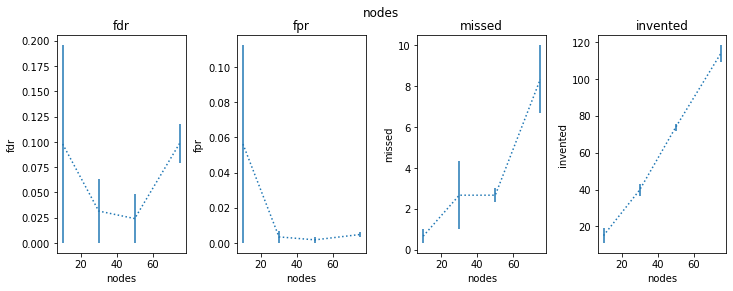

In [419]:
compare_multiple_plots(df_xs, df_mean_plot_values,df_min_plot_values,df_max_plot_values,  ['fdr','fpr','missed','invented'], 'Nodes')

In [423]:
degree

,fdr,tpr,fpr,shd,pred_size,loss,G_,G,seed,n,n_edges,missed,invented
family,,,,,,,,,,,,,
2,0.111111,0.960000,0.018182,3,27,0.005399,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",41,20,25,1,24
4,0.100000,0.900000,0.018750,5,30,0.003844,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",41,20,30,3,27
5,0.090909,0.930233,0.027211,7,44,0.017307,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",41,20,43,3,40
7,0.383562,0.775862,0.212121,39,73,0.065587,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",41,20,58,13,45
2,0.000000,1.000000,0.000000,0,24,0.005797,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",42,20,24,0,24
4,0.125000,0.875000,0.025316,7,32,0.007643,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",42,20,32,4,28
5,0.155172,0.890909,0.066667,14,58,0.125074,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",42,20,55,6,49
7,0.333333,0.818182,0.217742,37,81,0.207411,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",42,20,66,12,54
2,0.000000,0.916667,0.000000,1,11,0.007139,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",43,20,12,1,11


In [420]:
xs, mean_plot_values,min_plot_values,max_plot_values = mean_min_max_from_seed_dataframe(degree)

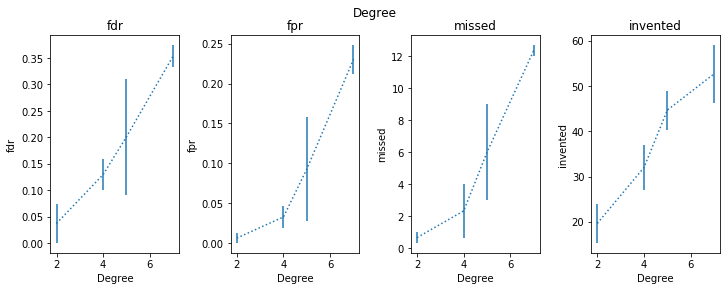

In [421]:
compare_multiple_plots(xs, mean_plot_values, max_plot_values, min_plot_values,  ['fdr','fpr','missed','invented'], 'Degree')

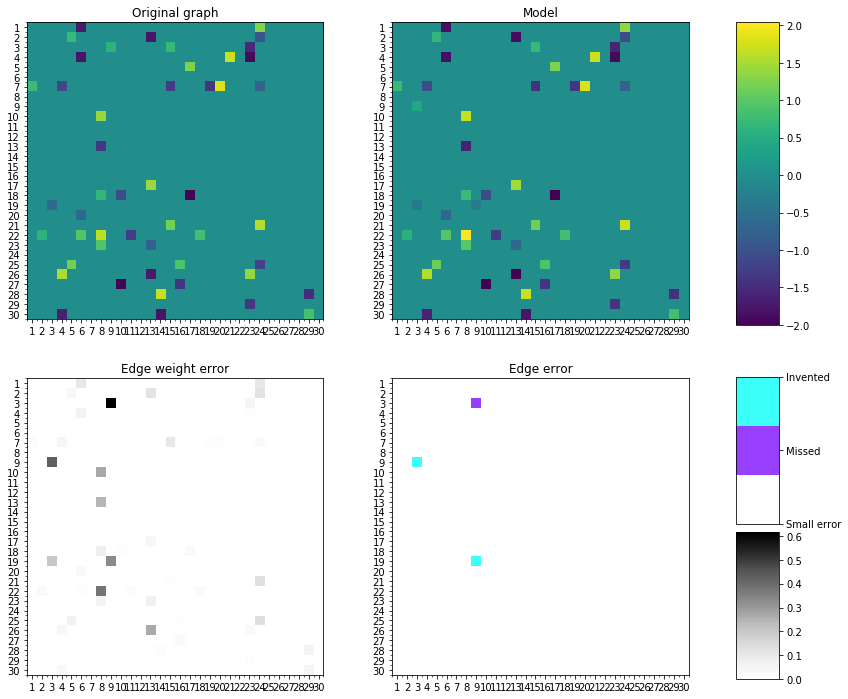

In [424]:
utils.plot_graphs(nodes_dict[30]['G'], nodes_dict[30]['G_'])
